
{% include toc title="In This Lesson" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this tutorial, you will be able to:

* 

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson and the
data for week 6 of the course.

{% include/data_subsets/course_earth_analytics/_data-cold-springs-fire.md %}
</div>


Intro here.

In [41]:
import rasterio as rio
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from rasterio.plot import show
import numpy as np
from glob import glob
plt.ion()

mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.titlesize'] = 20

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))


When working with multi-band rasters in python that are stored in a format where each file contains one band, you will often begin by creating a list of files. Do that first. 

In [42]:
all_landsat_bands = glob("data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/*band*.tif")
all_landsat_bands


['data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band1_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band2_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band3_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band4_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band5_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band6_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_201702

In [47]:
# get just cir bands to make a cir raster stack and tif
cir_bands = [all_landsat_bands[i] for i in (4,3,2)]
cir_bands

['data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band5_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band4_crop.tif',
 'data/cold-springs-fire/landsat_collect/LC080340322016070701T1-SC20180214145604/crop/LC08_L1TP_034032_20160707_20170221_01_T1_sr_band3_crop.tif']


If you wish to only work with a select subset of those bands - for instance to plot the data, you might want to do the following.

1. define the bands that you wish to work with
2. import those bands into a numpy array
3. OPTIONAL: if you'd like to plot the data, you will need to transpose it so the bands (the z dimension of the data) are on the z axis. Matplotlib requires this. 

The code below performs the steps defined above. 


## Python Raster Stack Function

You can turn the steps above into a function with very little extra work. Once it's a function, it will reduce the amount of code that you need to write each time you import some data. 

In [44]:
# The function below is a part of the earthpy package. It accepts a list of rasterio dataset objects
# it takes each object and loops through to merge them.
# IMPT: this will likely FAILY if any of the objects have different extents or CRS

def stack(sources, dest):
    """Stack a set of bands into a single file.

    Parameters
    ----------
    sources : list of rasterio dataset objects
        A list with paths to the bands you wish to stack. Objects
        will be stacked in the order provided in this list.
    dest : a rio.open writable object that will store raster data.
    """

    #if not os.path.exists(os.path.dirname(dest)):
    #    raise ValueError("The output directory path that you provided does not exist")

    if not type(sources[0]) == rio._io.RasterReader:
        raise ValueError("The sources object should be of type: rasterio.RasterReader")

    for ii, ifile in enumerate(sources):
            bands = sources[ii].read()
            if bands.ndim != 3:
                bands = bands[np.newaxis, ...]
            for band in bands:
                dest.write(band, ii+1)

Once you have written your function, call it as follows.

The function below takes a list of files paths and and output path where it will save a new .tif file
This funciton is a part of the earthpy package as well. 

Note that all files are opened and closed using context managers. This ensures that you don't have any lingering open file connections!

In [45]:
def stack_raster_tifs(band_paths, out_path):
    """Take a list of raster paths and turn into an ouput raster stack.
    Note that this function depends upon the stack() function to be submitted to rasterio.
    but the stack function ins't stand alone as written

    Parameters
    ----------
    band_paths : list of file paths
        A list with paths to the bands you wish to stack. Bands
        will be stacked in the order given in this list.
    out_path : string
        A path for the output stacked raster file.
    """
    # set default import to read
    kwds = {'mode': 'r'}

    if not os.path.exists(os.path.dirname(out_path)):
        raise ValueError("The output directory path that you provided does not exist")

    # the with statement ensures that all files are closed at the end of the with statement
    with contextlib.ExitStack() as context:
        sources = [context.enter_context(rio.open(path, **kwds)) for path in band_paths]

        dest_kwargs = sources[0].meta
        dest_count = sum(src.count for src in sources)
        dest_kwargs['count'] = dest_count

        # save out a stacked gtif file
        with rio.open(out_path, 'w', **dest_kwargs) as dest:
            return stack(sources, dest)

To quickly stack a list of tif files of the same extent and CRS, do the following

1. generate a list of files that you wish to stack. We have on already called `all_landsat_bands`
2. provide an output directory where a new stacked .tif file can be saved. 
3  use es.raster_stack_tifs() to create your stack

TypeError: list indices must be integers or slices, not list

In [48]:
# Stack all of the tif files into a new raster 
out_path = "data/cold-springs-fire/outputs/stacked-landsat.tif"
es.stack_raster_tifs(all_landsat_bands, out_path)


/Users/lewa8222/anaconda3/envs/earth-analytics-python/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Once you have done this, you can import the new stacked raster and work with it.


In [49]:
with rio.open(out_path) as src:
    all_landsat_bands = src.read()

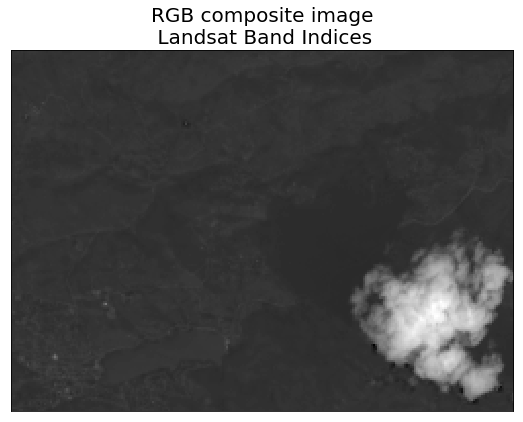

In [53]:
# now plot a single band from the stack
fig, ax = plt.subplots(figsize =(9,9))
ax.imshow(all_landsat_bands[0], cmap="gray")
ax.set(title="RGB composite image\n Landsat Band Indices")
ax.set(xticks=[], yticks=[]);

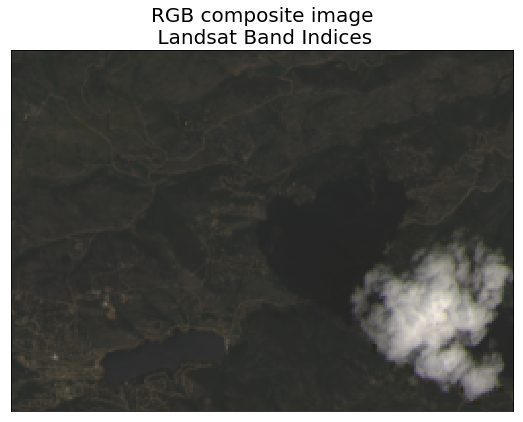

In [54]:
# now plot three bands using indexing
# you need to transpose the data given the shape that matplotlib expects

fig, ax = plt.subplots(figsize =(9,9))
ax.imshow(es.bytescale(all_landsat_bands)[[3,2,1]].transpose(1, 2, 0))
ax.set(title="RGB composite image\n Landsat Band Indices")
ax.set(xticks=[], yticks=[]);

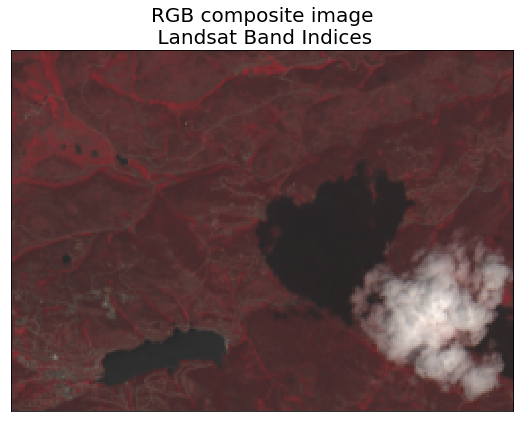

In [55]:
# Here is a color IR image
# why is it so muddy?
fig, ax = plt.subplots(figsize =(9,9))
ax.imshow(es.bytescale(all_landsat_bands)[[4,3,2]].transpose(1, 2, 0))
ax.set(title="RGB composite image\n Landsat Band Indices")
ax.set(xticks=[], yticks=[]);

## Plot RGB Image

Once you have created a 3 band matrix, you can plot it. 
Be sure that you set `transpose = True` if you want to plot the data!

Let's try this out with different band combinations!

In [ ]:
band_numbers = [4, 3, 2]
cir_image = stack_raster(band_indices = band_numbers, 
                         file_list = all_landsat_bands,
                         transpose = True)
fig, ax = plt.subplots(figsize =(9,9))
# switch this to el.bytescale 
ax.imshow(bytescale(cir_image))
ax.set(title="CIR composite image\n Landsat Band Indices: {}".format(band_numbers))
ax.set(xticks=[], yticks=[]);

### Add Image Stretch To Your Function

The function above quickly stacks and transposes the data. However, the data are still 
plotting dark. It would be nice to add an image stretch capability to the function. 


In [ ]:
band_numbers = [3, 2, 1]
rgb_image = stack_raster2(band_indices = band_numbers, 
                         file_list = all_landsat_bands,
                         transpose = True)

In [ ]:
# stretch the image so that it plots nicer. 
# the stretch below clips at the 2nd and 98th percentile
# http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

from skimage import data, img_as_float
from skimage import exposure

all_bands = []
for i in range(rgb_image.shape[2]):
    band = rgb_image[:,:,i]
    #print(band.shape)
    p2, p98 = np.percentile(band, (2, 98))
    img_rescale = exposure.rescale_intensity(band, in_range=(p2, p98))
    all_bands.append(img_rescale)
    

#rgb_image_stretch = np.array(all_bands).transpose([1, 2, 0])
type(rgb_image_stretch)
rgb_image_stretch.shape

## Add image stretch as a function



# Need to revisit this as the colors still don't look right. 

In [ ]:
# plot the data 
fig, ax = plt.subplots()
ax.imshow(bytescale(rgb_image_stretch))
ax.set(title="RGB composite image Landsat Bands(4,3,2) \npython band indices: {}".format(plot_indices))
ax.set(xticks=[], yticks=[]);

## NDVI FUnction here

Below i'll start to work on some index functions.

A generic calculate normalized difference function will be good and widely useable.



In [ ]:
# calculate NDVI
# this is super insanely crazy

band_numbers = [3, 4]
ndvi_bands = stack_raster2(band_indices = band_numbers, 
                         file_list = all_landsat_bands,
                         transpose = False)
ndvi_bands.shape

In [ ]:
# calculate NDVI
landsat_ndvi = (ndvi_bands[1] - ndvi_bands[0]) / (ndvi_bands[1] + ndvi_bands[0])
# plot the data 
fig, ax = plt.subplots(figsize=(12,6))
ndvi = ax.imshow(landsat_ndvi, cmap='PiYG')
fig.colorbar(ndvi)
ax.set(title="Landsat derived NDVI\n 23 July 2016 \n Post Cold Springs Fire")
ax.set_axis_off();